# Load datasets

Download datasets from bucket

Load test and train sets

In [15]:
import torch
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), 
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),  
])

train_data_path = 'data/train/casia-100'
test_data_path = 'data/test/casia-100'

batch_size = 64

train_data = datasets.ImageFolder(train_data_path, transform=train_transform)
train_loader = torch.utils.data.DataLoader(
    train_data, shuffle=True, batch_size=batch_size)

test_data = datasets.ImageFolder(test_data_path, transform=train_transform)
test_loader = torch.utils.data.DataLoader(
    test_data, shuffle=True, batch_size=batch_size)

# Init the model

In [16]:
from torchvision.models import resnet18, ResNet18_Weights
from torch import nn, optim
import os
model = resnet18()

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

# Train and validate the model

functions for training and validating

In [17]:
import time
import datetime
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def get_accuracy(model: nn.Module, train=False):
    correct = 0
    total = 0
    n = 0
    loader = train_loader if train else test_loader 
    predictions, label_list = [], []
    with torch.no_grad():
        for imgs, labels in iter(loader):
            imgs, labels = imgs.to(device), labels.to(device)
            model.eval()
            output = model(imgs).data
            pred = output.max(1)[1]
            correct += pred.eq(labels.data).sum().item()
            total += imgs.shape[0]
            predictions.append(pred)
            label_list.append(labels)
            n += 1
    return correct / total, predictions, label_list

def plot_training_curve(iters, losses, epochs, train_acc, val_acc):
    plt.title("Learning Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    #save plot to file
    time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    plt.savefig("figures/loss_curve_{}.png".format(time))

    plt.title("Learning Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    plt.savefig("figures/learning_curve_{}.png".format(time))

def train(
    learning_rate = 0.01,
    num_epochs = 15,
    weight_decay = 0.0,
    momentum = 0.9,
    output_to_file = True,
    always_output = True, 
    eval = True,
    data_loader = train_loader,
    loss_output_mod = 10,
    filename_prefix = 'model',
    savestate = True,
    ):

    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        model.fc.parameters(),
        lr=learning_rate,
        momentum=momentum,
        weight_decay=weight_decay
        )

    if output_to_file:
        outputfile = open(filename_prefix+'_'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'.txt', 'w')

    def output(text):
        if output_to_file:
            outputfile.write(text + '\n')
        else:
            print(text)

    iters, losses, train_acc, val_acc, epochs = [], [], [], [], []

    n = 0
    for epoch in range(num_epochs):
        epoch_tic = time.perf_counter()
        for imgs, labels in iter(data_loader):
            tic = time.perf_counter()
            imgs = imgs.to(device)
            labels = labels.to(device)

            model.train()

            out = model(imgs)
            loss = loss_fn(out, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            toc = time.perf_counter()

            if (n % loss_output_mod == 0) or always_output:
                output('epoch: {}, iter: {}, loss: {}, time: {}'.format(epoch, n, loss, toc - tic))
            if eval:
                iters.append(n)
                losses.append(float(loss)/batch_size) # compute *average* loss
            n += 1
        
        epochs.append(epoch)

        if eval: 
            curr_train_acc = get_accuracy(model, train=True)[0]
            curr_val_acc = get_accuracy(model, train=False)[0]
            train_acc.append(curr_train_acc) # compute training accuracy 
            val_acc.append(curr_val_acc)  # compute validation accuracy
            output("Train accuracy: {}".format(curr_train_acc))
            output("Validation accuracy: {}".format(curr_val_acc))
        
        if savestate:
            torch.save(model.state_dict(), 'model-states/' + filename_prefix + '_epoch_' + str(epoch) + '.pt')

        epoch_toc = time.perf_counter()
        output('epoch: {}, time: {}'.format(epoch, epoch_toc - epoch_tic))
        if output_to_file:
            outputfile.flush()

    if eval: 
        output("Final Training Accuracy: {}".format(train_acc[-1]))
        output("Final Validation Accuracy: {}".format(val_acc[-1]))
        plot_training_curve(iters, losses, epochs, train_acc, val_acc)
    else: 
        torch.save(model.state_dict(), 'model-states/' + filename_prefix + '_final.pt')
        output("Final Training Accuracy: {}".format(get_accuracy(model, train=True)[0]))
        # output("Final Validation Accuracy: {}".format(get_accuracy(model, train=False)))
    
    if output_to_file:
        outputfile.close()
    
    if eval:
        return get_accuracy(model, train=True)


Load digiface pretrained model

In [18]:
num_classes_pretrain = 2000
model.fc = nn.Linear(512, num_classes_pretrain)
model.load_state_dict(torch.load('digiface_pretrained_v4_final.pt', map_location=torch.device('mps')))

<All keys matched successfully>

Freeze params

In [19]:
#freeze all layers
for param in model.parameters():
    param.requires_grad = False

Add a last classifier layer

In [20]:
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=512, 
                    out_features=100, # same number of output units as our number of classes
                    bias=True)).to(device)

Finetune digiface pretrained

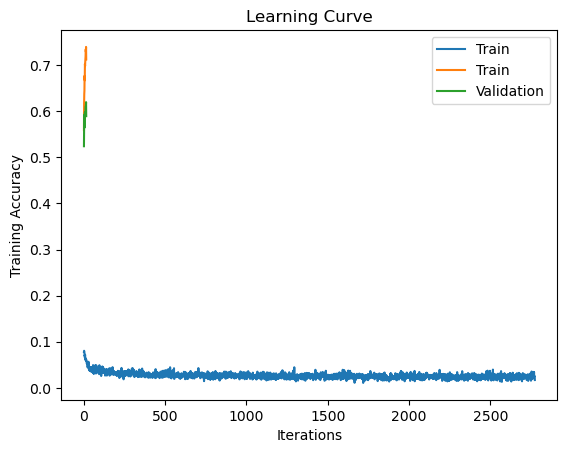

In [21]:
model.to(device)

precision1, predictions1, label_list1 = train(
    eval=True,
    data_loader=train_loader,
    output_to_file=True,
    always_output=False,
    loss_output_mod=10,
    savestate=True,
    filename_prefix='digiface_pretrained/v4_finetune',
)

In [26]:
print(precision1)

0.7121289228159458


Load imagenet pretrained model
freeze params
add last layer

In [22]:
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=512, 
                    out_features=100, # same number of output units as our number of classes
                    bias=True)).to(device)

Finetune imagenet pretrained

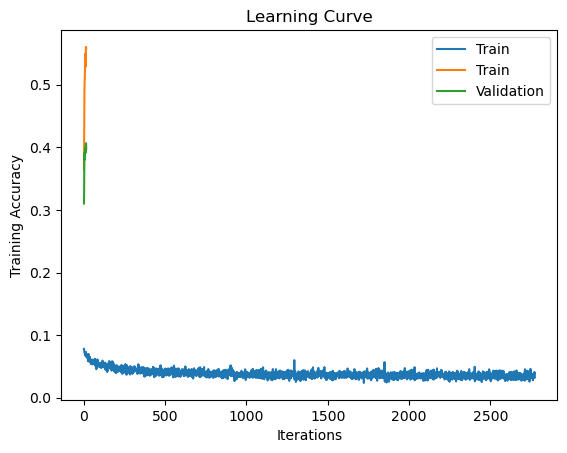

In [23]:
model.to(device)

precision2, predictions2, label_list2 = train(
    eval=True,
    data_loader=train_loader,
    output_to_file=True,
    always_output=False,
    loss_output_mod=10,
    savestate=True,
    filename_prefix='imagenet_pretrained/v1_finetune',
)

Load model with no pretrained weights
freeze params
add last layer

In [24]:
model = resnet18()
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=512, 
                    out_features=100, # same number of output units as our number of classes
                    bias=True)).to(device)

Finetune model with no pretrained weights

In [ ]:
model.to(device)

precision3, predictions3, label_list3 = train(
    eval=True,
    data_loader=train_loader,
    output_to_file=True,
    always_output=False,
    loss_output_mod=10,
    savestate=True,
    filename_prefix='no_pretrain/v1_finetune',
)

Load casia pretrained model

In [29]:
num_classes_pretrain = 2000
model.fc = nn.Linear(512, num_classes_pretrain)
model.load_state_dict(torch.load('casia_pretrained_v4_final.pt', map_location=torch.device('mps')))

<All keys matched successfully>

In [30]:
#freeze all layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=512, 
                    out_features=100, # same number of output units as our number of classes
                    bias=True)).to(device)

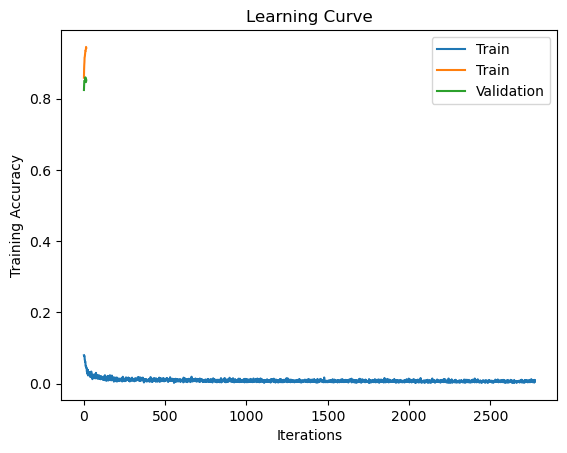

In [31]:
model.to(device)

precision4, predictions4, label_list4 = train(
    eval=True,
    data_loader=train_loader,
    output_to_file=True,
    always_output=False,
    loss_output_mod=10,
    savestate=True,
    filename_prefix='casia_pretrained/v1_finetune',
)

Load models again for testing

In [28]:
# model_digi = model.load_state_dict(torch.load('model-states/digiface_pretrained/v4_finetune_epoch_14.pt', map_location=torch.device('mps')))
# model_imagenet = model.load_state_dict(torch.load('model-states/imagenet_pretrained/v1_finetune_epoch_14.pt', map_location=torch.device('mps')))
# model_nopre = model.load_state_dict(torch.load('model-states/no_pretrain/v1_finetune_epoch_14.pt', map_location=torch.device('mps')))